In [27]:
!sudo apt -y install libportaudio2
%pip install tflite-model-maker

正在读取软件包列表... 完成0%
正在分析软件包的依赖关系树... 完成%
正在读取状态信息... 完成                   
libportaudio2 已经是最新版 (19.6.0-1.1)。
升级了 0 个软件包，新安装了 0 个软件包，要卸载 0 个软件包，有 0 个软件包未被升级。
Note: you may need to restart the kernel to use updated packages.


In [28]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

TensorFlow Version: 2.8.4
Model Maker Version: 0.4.2


In [29]:
data_dir = './dataset'

test_files = os.path.abspath(os.path.join(data_dir, 'test/*/*.wav'))

In [30]:
def get_random_audio_file():
    test_list = glob.glob(f'{data_dir}/test/snoring/*.wav')
    random_audio_path = random.choice(test_list)
    return random_audio_path


def show_data(audio_path):
    print(audio_path)
    sample_rate, audio_data = wavfile.read(audio_path, 'rb')

    plt.title('Snoring Audio')
    plt.plot(audio_data)
    display(Audio(audio_data, rate=sample_rate))


print('functions and data structures created')

functions and data structures created


In [31]:
# random_audio = get_random_audio_file()
# show_data(random_audio)

In [32]:
spec = audio_classifier.YamNetSpec(
    keep_yamnet_and_custom_heads=False,
    frame_step=audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,
    frame_length=audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)

INFO:tensorflow:Checkpoints are stored in /tmp/tmp7qk0pw7f


INFO:tensorflow:Checkpoints are stored in /tmp/tmp7qk0pw7f


In [33]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=True)
train_data, validation_data = train_data.split(0.8)
test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=True)

In [34]:
batch_size = 128
epochs = 25

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 3)                3075      
                                                                 
Total params: 3,075
Trainable params: 3,075
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
4/4 [==============================] - 8s 775ms/step - loss: 1.3635 - acc: 0.2318 - val_loss: 1.1838 - val_acc: 0.2097
Epoch 2/25
4/4 [==============================] - 0s 106ms/step - loss: 1.0336 - acc: 0.4136 - val_loss: 0.9555 - val_acc: 0.4919
Epoch 3/25
4/4 [==============================] - 0s 86ms/step - loss: 0.8239 - acc: 0.6250 - val_loss: 0.7923 - val_acc: 0.6613
Epoch 4/25
4/4 [==============================] - 0s 82ms/step - loss: 0.6367 - acc: 0.7909 - val_loss: 0.6832 - val_acc: 0.6855
Epoch 5/25
4/4 [===========================

In [35]:
print('Evaluating the model')
model.evaluate(test_data)

Evaluating the model
5/5 [==============================] - 2s 257ms/step - loss: 0.1497 - acc: 0.9858


[0.1497221142053604, 0.9858155846595764]

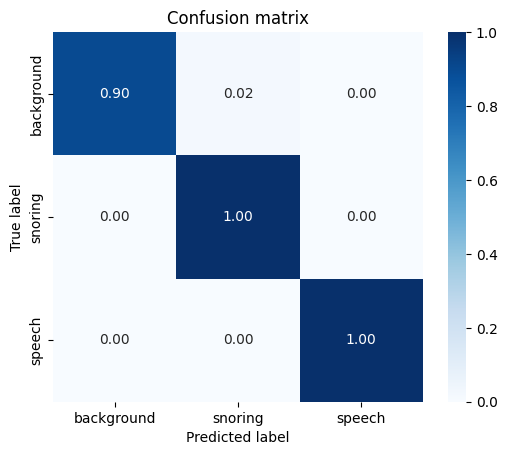

In [36]:
def show_confusion_matrix(confusion, test_labels):
    """Compute confusion matrix and normalize."""
    confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
    axis_labels = test_labels
    ax = sns.heatmap(
        confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
        cmap='Blues', annot=True, fmt='.2f', square=True)
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [37]:
serving_model = model.create_serving_model()

print(f'Model\'s input shape and type: {serving_model.inputs}')
print(f'Model\'s output shape and type: {serving_model.outputs}')

Model's input shape and type: [<KerasTensor: shape=(None, 15600) dtype=float32 (created by layer 'audio')>]
Model's output shape and type: [<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'sequential_2')>]


In [38]:
models_path = './snoring_models'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='snoring_model.tflite')

Exporing the TFLite model to ./snoring_models
INFO:tensorflow:Assets written to: /tmp/tmp0jz0a2zk/assets


INFO:tensorflow:Assets written to: /tmp/tmp0jz0a2zk/assets
2022-12-14 21:47:17.719105: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-14 21:47:17.719184: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-12-14 21:47:17.719337: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2022-12-14 21:47:17.719870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-14 21:47:17.719900: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the gui

Estimated count of arithmetic ops: 141.089 M  ops, equivalently 70.545 M  MACs
INFO:tensorflow:TensorFlow Lite model exported successfully: ./snoring_models/snoring_model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./snoring_models/snoring_model.tflite


In [39]:
model.export(models_path, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

INFO:tensorflow:Assets written to: ./snoring_models/saved_model/assets


INFO:tensorflow:Assets written to: ./snoring_models/saved_model/assets


INFO:tensorflow:Saving labels in ./snoring_models/labels.txt


INFO:tensorflow:Saving labels in ./snoring_models/labels.txt
